In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import datasets, transforms

In [2]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

### 1. Configurare

In [3]:
BATCH_SIZE = 64
LR = 0.001
EPOCHS = 10  # CIFAR-10 is harder, requires more epochs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# CIFAR-10 classes
CLASSES = ('avion', 'auto', 'pasare', 'pisica', 'cerb',
           'caine', 'broasca', 'cal', 'nava', 'camion')

### 2. Descărcăm și pregătim datele

In [5]:
# CIFAR-10 has 3 channels (RGB). Mean and Std are approximatively 0.5 for each channel.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100.0%


### 3. Definim arhitectura rețelei neuronale

In [ ]:
class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()
        # Conv Block 1: Input 3 channels (RGB)x32x32 -> Output 32x32x32
        # Padding=1 keeps the original size (32x32) before pooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        # Max Pool: Output 32x16x16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv Block 2: Input 32x16x16 -> Output: 64x16x16
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Max Pool: Output 64x8x8

        # Conv Block 3 (Added for complexity)
        # Input 64 -> Output 64
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # Max Pool: Output 64x4x4

        # Fully Connected Layers
        # 64 channels x 4 x 4 image size
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 Classes

    def forward(self, x):
        # Layer 1
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Layer 2
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Layer 3
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten
        x = torch.flatten(x, 1)

        # Dense Layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### 4. Inițializăm CNN-ul și funcțiile ajutătoare

In [ ]:
model = AnimalCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

Verificăm arhitectura modelului, afișând rezumatul

In [8]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          36,928
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Linear-10                  [-1, 128]         131,200
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 188,810
Trainable params: 188,810
Non-trainable params: 0
-------------------------------

### 5. Antrenăm CNN-ul și urmărim evoluția

In [9]:
loss_history = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {avg_loss:.4f}")

Epoch 1/10, Loss: 1.4517
Epoch 2/10, Loss: 1.0416
Epoch 3/10, Loss: 0.8530
Epoch 4/10, Loss: 0.7422
Epoch 5/10, Loss: 0.6590
Epoch 6/10, Loss: 0.5901
Epoch 7/10, Loss: 0.5264
Epoch 8/10, Loss: 0.4722
Epoch 9/10, Loss: 0.4199
Epoch 10/10, Loss: 0.3824


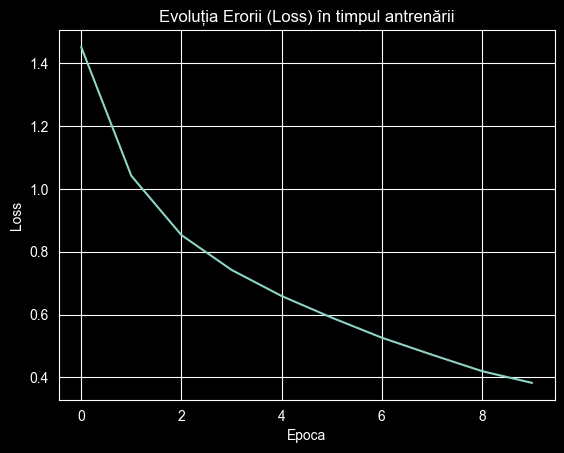

In [10]:
plt.plot(loss_history)
plt.title("Evoluția Erorii (Loss) în timpul antrenării")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.show()

### 6. Validăm modelul antrenat

In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct / total:.2f}%')
# Note: On CIFAR-10 a simpler network achieves ~60-70%. A lot less than 99% on MNIST.

Acuratețe pe setul de test: 73.33%


### 7. Matrice de Confuzie și Exemple Greșite

In [12]:
def get_all_preds(model, loader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(DEVICE)
            preds = model(images)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

In [13]:
test_preds, test_labels = get_all_preds(model, test_loader)

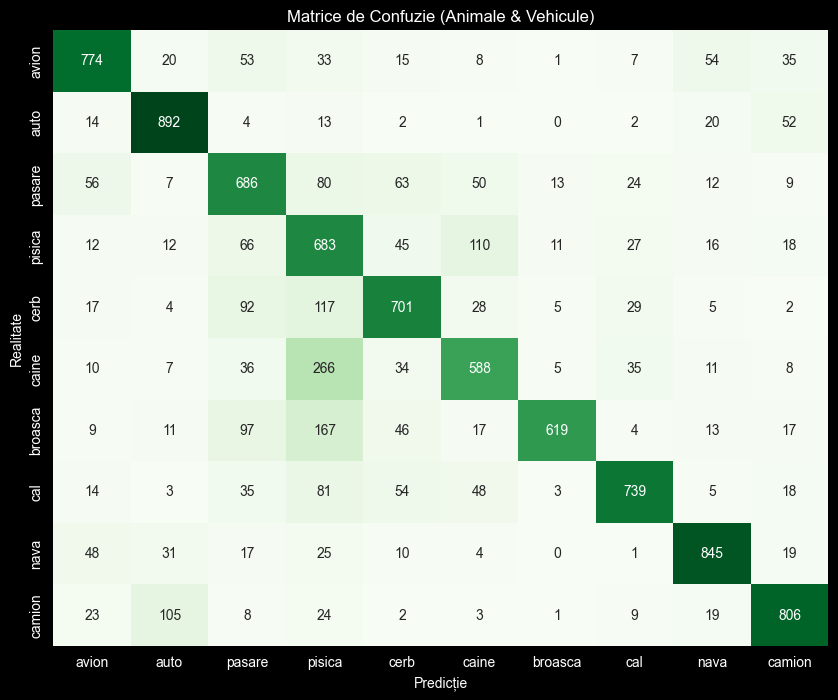

In [14]:
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Afișare exemple clasificate greșit

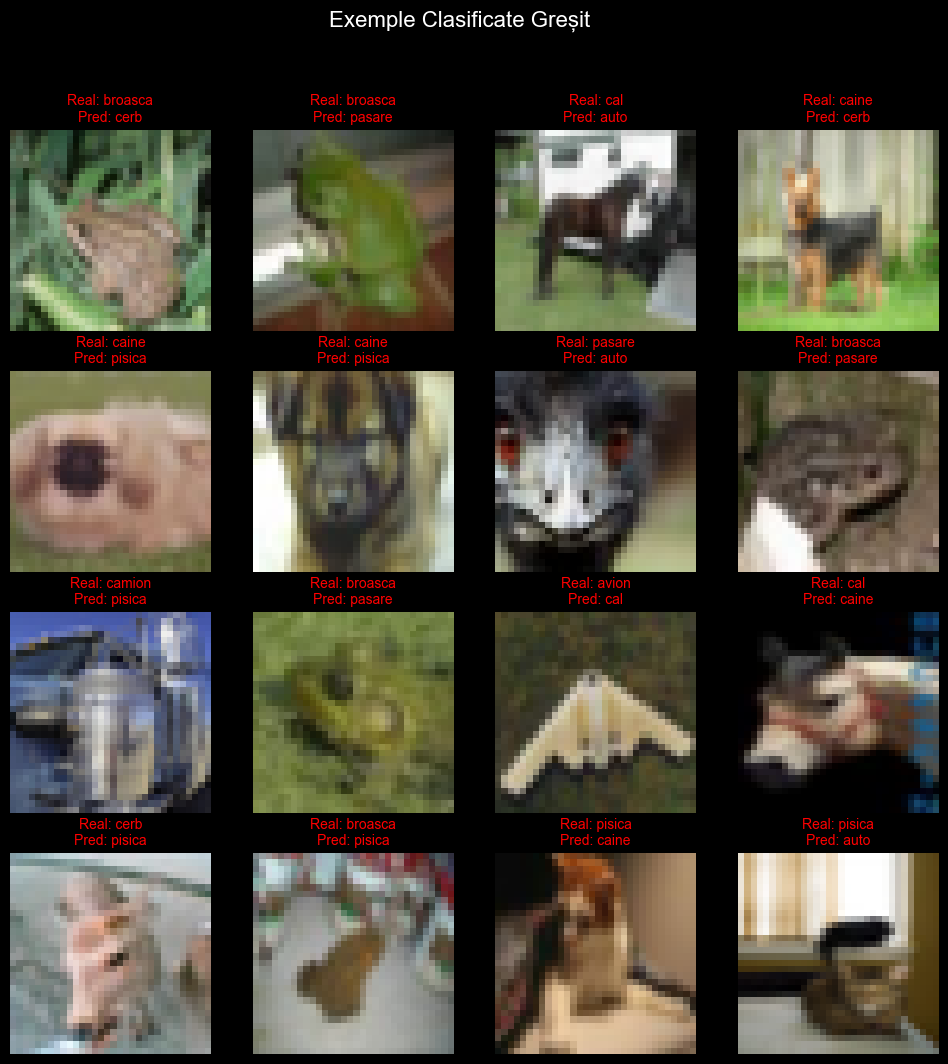

In [15]:
misclassified_idxs = np.where(test_preds != test_labels)[0]
figure = plt.figure(figsize=(12, 12))
rows, cols = 4, 4

for i in range(min(16, len(misclassified_idxs))):
    idx = misclassified_idxs[i]
    img, label = test_dataset[idx]  # Get original image
    pred_label = test_preds[idx]

    figure.add_subplot(rows, cols, i + 1)

    # Un-normalize for display: img * std + mean
    # (0.5, 0.5, 0.5) are the transform values
    img_display = img.permute(1, 2, 0) * 0.5 + 0.5

    plt.imshow(img_display)
    plt.title(f"True: {CLASSES[label]}\nPred: {CLASSES[pred_label]}", color="red", fontsize=10)
    plt.axis("off")

plt.suptitle("Misclassified Examples", fontsize=16)
plt.show()